# PC Session 1

# **Machine Learning for Prediction**

**Authors:**
[Anthony Strittmatter](http://www.anthonystrittmatter.com),
[Helge Liebert](https://hliebert.github.io/), and
Jonathan Chassot

You want to buy an used car at the online auction platform *MyLemons*. You are worried that many used cars on this platform are overpriced. Therefore, you want to do some market research before you buy an used car. For this purpose, you web-scrape the used car offers on the *MyLemons* platform. You obtain the following variables:

|Variable name| Description|
|:----|:----|
|**Outcome variables** ||
|*first_price*| First asking price in 1,000 CHF |
|*final_price*| Transaction price in 1,000 CHF|
|*overprice*| Dummy indicating *first_price > final_price* |
|**Baseline covariates**| |
|*bmw_320, opel_astra, mercedes_c, vw_golf, vw_passat*| Dummies for the car make and model|
|*mileage*| Mileage of the used car (in 1,000 km)|
|*age_car_years*| Age of the used car (in years)|
|*diesel*| Dummy for diesel engines |
|*private_seller*| Dummy for private seller (as opposed to professional used car sellers) |
|*other_car_owner*| Number of previous caar owners |
|*guarantee*| Dummy indicating that the seller offers a guarantee for the used car|
|*maintenance_cert*| Dummy indicating that the seller has a complete maintenace certificate for the used car|
|*inspection*| Categorial variable for the duration until next general inspection (3 categories: new, 1-2 years, > 2 years) |
|*pm_green*| Dummy indicating that the used car has low particular matter emissions|
|*co2_em*| CO2 emssion (in liter per 100km)|
|*euro_norm*| EURO emission norm under which the car is registered |


Furthermore, you generate some transformations of your covariates that you want to use for later analysis. The transformed covariates are:

|Variable name| Description|
|:----|:----|
|**Additional covariates** ||
|*mileage2, mileage3, mileage4, age_car_years2, age_car_years3, age_car_years4*| Squared, cubic, and quadratic *mileage* and *age_car_years* |
|*mile_20, mile_30, mile_40, mile_50, mile_100, mile_150*| Dummies indicating that the used car has a mileage above 20,000km, 30,000km, 40,000km, 50,000km, 100,000km, or 150,000km |
|*age_3, age_6*| Dummies indicating that the used car is above 3 or 6 years old |
|*dur_next_ins_1_2*| Dummy indicating that the duration until the next general inspection is between 1 and 2 years |
|*new_inspection*| Dummy indicating that the used car has a new general inspection |


You store the prepared data in the file *used_cars.csv*. Now you start you analysis. 


## Load Packages

In the first place, you install and load the R-packages you want to use.

In [57]:
########################  Load Packages  ########################

# List of required packages
pkgs <- c('fBasics', 'corrplot', 'psych', 'glmnet', 'glmnetUtils', 'rpart',
          'rpart.plot', 'treeClust', 'randomForest', 'rlang', 'readr', 'devtools',
          'tidyverse', 'grf', 'reshape2', 'caret', 'neuralnet', 'dmlmt')


# Load packages (install if needed)
for(pkg in pkgs){
    if(!(pkg %in% rownames(installed.packages()))){
        install.packages(pkg, repos="http://stat.ethz.ch/CRAN")
    }
    library(pkg, character.only = TRUE)
}

print('All packages successfully installed and loaded.')

[1] "All packages successfully installed and loaded."


## Load Data Frame

Now you load the data frame and define different covariate categories. You distinguish between binary and continuous/discrete covariates. Furthermore, you decrease the sample size to 10,000 in order to decrease the computation time while you are testing your code. You plan to use the entire sample of 78,645 used cars after you are finised with programming.

In [58]:
########################  Load Data Frame  ########################

set.seed(100231) # set starting value for random number generator

# Load data frame
data_raw <- read.csv("used_cars.csv",header=TRUE, sep=",")

# Outcome Variables
outcomes <- c("first_price", "final_price", "overprice")

# Covariates/Features
baseline_covariates_bin <- c("bmw_320", "opel_astra", "mercedes_c", "vw_golf", "vw_passat", 
                          "diesel",   "private_seller", "guarantee", "maintenance_cert",  "pm_green") # binary
baseline_covariates_cont <- c("mileage", "age_car_years", "other_car_owner", "inspection",
                              "co2_em", "euro_norm") # continuous/discrete
baseline_covariates <- c(baseline_covariates_cont,baseline_covariates_bin)
lasso_covariates_bin <- c("mile_20", "mile_30", "mile_40", "mile_50", "mile_100", "mile_150", 
                       "age_3", "age_6", "dur_next_ins_1_2", "new_inspection") # binary 
lasso_covariates_cont <- c("mileage2", "mileage3", "mileage4", "age_car_years2", "age_car_years3",
                           "age_car_years4") # continuous/discrete

lasso_covariates <- c(lasso_covariates_cont, lasso_covariates_bin)  
all_covariates <- c(baseline_covariates, lasso_covariates)
all_variables <- c(outcomes, all_covariates)

# Selection of Subsample size, max. 78,645 observations
# Select smaller subsample to decrease computation time
n_obs <- 10000
df <- data_raw %>%
  dplyr::sample_n(n_obs) %>%
  dplyr::select(all_variables)

print('Data frame successfully loaded and sample selected.')

[1] "Data frame successfully loaded and sample selected."


## Descriptive Statistics

### Means and Standard Deviations

Now you have a look at the descriptive statistics to check for data errors and missing values.

In [59]:
########################  Table with Descriptive Statistics  ########################

desc <- fBasics::basicStats(df) %>% t() %>% as.data.frame() %>% 
  select(Mean, Stdev, Minimum, Maximum, nobs)
print(round(desc, digits=1))

# Print as tex-file
#kable(desc, "latex", booktabs = T)

                        Mean       Stdev Minimum      Maximum  nobs
first_price             15.6         7.4       1        100.5 10000
final_price             15.2         7.1       1         98.7 10000
overprice                0.6         0.5       0          1.0 10000
mileage                100.4        49.8      10        200.0 10000
age_car_years            4.6         2.6       1         19.4 10000
other_car_owner          1.1         0.7       0          6.0 10000
inspection               0.9         0.7       0          2.0 10000
co2_em                 138.8        24.9       1        249.0 10000
euro_norm                4.8         0.6       1          6.0 10000
bmw_320                  0.2         0.4       0          1.0 10000
opel_astra               0.1         0.3       0          1.0 10000
mercedes_c               0.1         0.3       0          1.0 10000
vw_golf                  0.2         0.4       0          1.0 10000
vw_passat                0.3         0.5       0

### Correlation Matrix

You plot the correlation matrix. The correlation structure between the covariates is important for the later interpretation of the results.

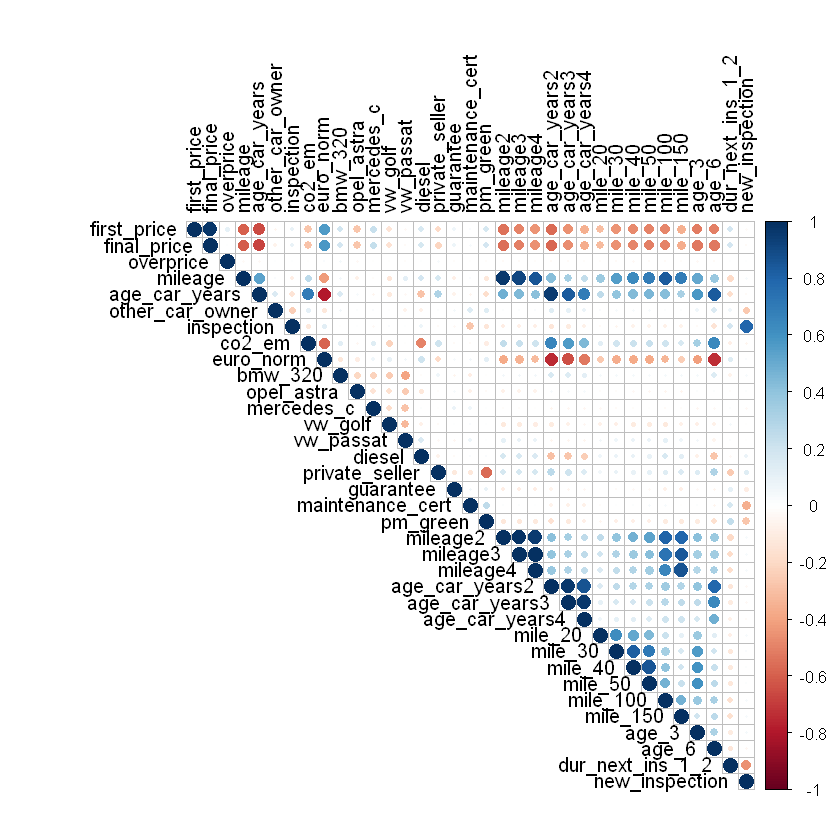

In [60]:
########################  Correlation Matrix  ########################

corr = cor(df)
corrplot(corr, type = "upper", tl.col = "black")

# Save correlation matrix as png-file
#png(height=1200, width=1200, file="correlation.png")
    #corrplot(corr, type = "upper", tl.col = "black")
#dev.off()


## Extract Data

You extract the different variable categories from your data frame and drop observations with missing values.

In [61]:
########################  Extract Dataset  ########################

# Extracting continuous variables
baseline_covariates_cont <- df %>%
  dplyr::select(baseline_covariates_cont) 

lasso_covariates_cont <- df %>%
  dplyr::select(lasso_covariates_cont) 

# Extracting indicator variables
baseline_covariates_bin <- df %>%
  dplyr::select(baseline_covariates_bin)

lasso_covariates_bin <- df %>%
  dplyr::select(lasso_covariates_bin)

# Extracting outcome 
outcomes <- df %>% dplyr::select(outcomes)

# Setting up the data, renaming columns and discarding rows with NA (if any)
df <- bind_cols(outcomes, baseline_covariates_cont, baseline_covariates_bin, lasso_covariates_cont, lasso_covariates_bin) %>%
  na.omit()

print('Data successfully extracted.')

[1] "Data successfully extracted."


## Take Hold-Out-Sample and Scale Data

You want to compare the relative prediction power of different estimation procedures based on the out-of-sample MSE and $R^2$. For this purpose, you create a training/estimation- and hold-out-sample. You will use the training/estimation-sample to train the machine learning procedures and estimate the final used car prices. Then you will extrapolate the results to the retared hold-out-sample.


Furthermore, you standardise the continuous covariates by the means and standard deviations in the training/estimation-sample. Some machine learning algorithms are sensitive to rescaling. Even though most machine learning procedures standardise the covariates automatically, this is a cautionary transformation for those procedures that have no automatic standardisation implemented.

In [62]:
########################  Take Hold-Out-Sample  ########################

df_part <- modelr::resample_partition(df, c(obs = 0.8, hold_out = 0.2))
df_obs <- as.data.frame(df_part$obs) # Training and estimation sample
df_hold_out <- as.data.frame(df_part$hold_out) # Hold-out-sample

# Outcomes
first_price_obs <- as.matrix(df_obs[,1])
final_price_obs <- as.matrix(df_obs[,2])
overprice_obs <- as.matrix(df_obs[,3])

first_price_hold_out <- as.matrix(df_hold_out[,1])
final_price_hold_out <- as.matrix(df_hold_out[,2])
overprice_hold_out <- as.matrix(df_hold_out[,3])

## Covariates/Features
baseline_covariates_cont_obs <- as.matrix(df_obs[,c(4:9)])
baseline_covariates_bin_obs <- as.matrix(df_obs[,c(10:19)])
baseline_covariates_hold_cont_out <- as.matrix(df_hold_out[,c(4:9)])
baseline_covariates_hold_bin_out <- as.matrix(df_hold_out[,c(10:19)])

# Standardise continuous variables
preProcValues <- preProcess(baseline_covariates_cont_obs, method = c("center", "scale")) # Take means and standard deviations from training sample
ObsTransformed <- predict(preProcValues, baseline_covariates_cont_obs) # Apply the transformation to trainings sample
HoldOutTransformed <- predict(preProcValues, baseline_covariates_hold_cont_out) # Apply the transformation to hold-out-sample (based on means and standard deviations from training sample)
# Note: Outcome variables are not rescaled

baseline_covariates_obs <- as.matrix(cbind(ObsTransformed,baseline_covariates_bin_obs)) 
baseline_covariates_hold_out <- as.matrix(cbind(HoldOutTransformed,baseline_covariates_hold_bin_out)) 
                  
print('The data is now ready for your first analysis!')

[1] "The data is now ready for your first analysis!"


# Tree Estimators

You start the prediction of the final used car price with a tree estimator. Trees partition the sample into mutually exclusive groups $l_j$, which are called terminal leaves. Let $\pi= \{ l_1, ...,l_{\# (\pi)} \}$ be a specific tree or sample partition, let $l_j \equiv l_j (x,\pi)$ be the respective terminal leaf (for $j=1,…,\#(\pi))$, and let $\#(\pi)$ be the number of terminal leaves in tree $\pi$. The terminal leaf $l_j (x,\pi)$ of tree $\pi$ is a function of the covariates $X_{i}$ (for $i = 1,..., N$ used cars) such that $x \in l_j$. 

For an explicit example, consider that $X_{i}$ contains only a binary indicator for used diesel cars. Then, you can choose between two possible trees; either you make no sample split, $\pi'=\{ l_1 \}=\{ \mbox{diesel}, \mbox{gasoline} \}$, or you partition used diesel and gasoline cars into two separate leaves, $\pi'' =\{ l_1,l_2 \}= \{ \{ \mbox{diesel} \}, \{ \mbox{gasoline} \} \}$.  

Trees select the partition $\pi$ by recursively adding leaves to the tree that minimise the MSE. Accordingly, trees aim to partition the sample into leaves with homogeneous outcomes. Because of the hierarchical partition structure, the first splits contribute more prediction power than the last splits. 


For a specific tree $\pi$, you can predict the final used car price by
\begin{equation*}
\hat{E}[final\_price|(x,\pi)] = \frac{1}{\sum_{i=1}^{N}1\{ X_{i} \in l_j(x,\pi)\}}\sum_{i=1}^{N} 1\{ X_{i} \in l_j(x,\pi)\} \cdot final\_price.
\end{equation*}



## Shallow Tree

You start the analysis with a reletively small (shallow) tree, by imposing that each terminal leave needs to contain at least 500 used cars.

[1] "Relative CV-MSE for different tree sizes"
          CP nsplit rel error    xerror       xstd
1 0.33147274      0 1.0000000 1.0002250 0.02664477
2 0.08550624      1 0.6685273 0.6689913 0.01995795
3 0.07344012      2 0.5830210 0.5835023 0.01968030
4 0.02234055      3 0.5095809 0.5114408 0.01749864
5 0.02064299      4 0.4872403 0.4872860 0.01805109
6 0.01443385      5 0.4665974 0.4731236 0.01777437
7 0.01323307      6 0.4521635 0.4605675 0.01772135
8 0.00002000      7 0.4389304 0.4463445 0.01768996


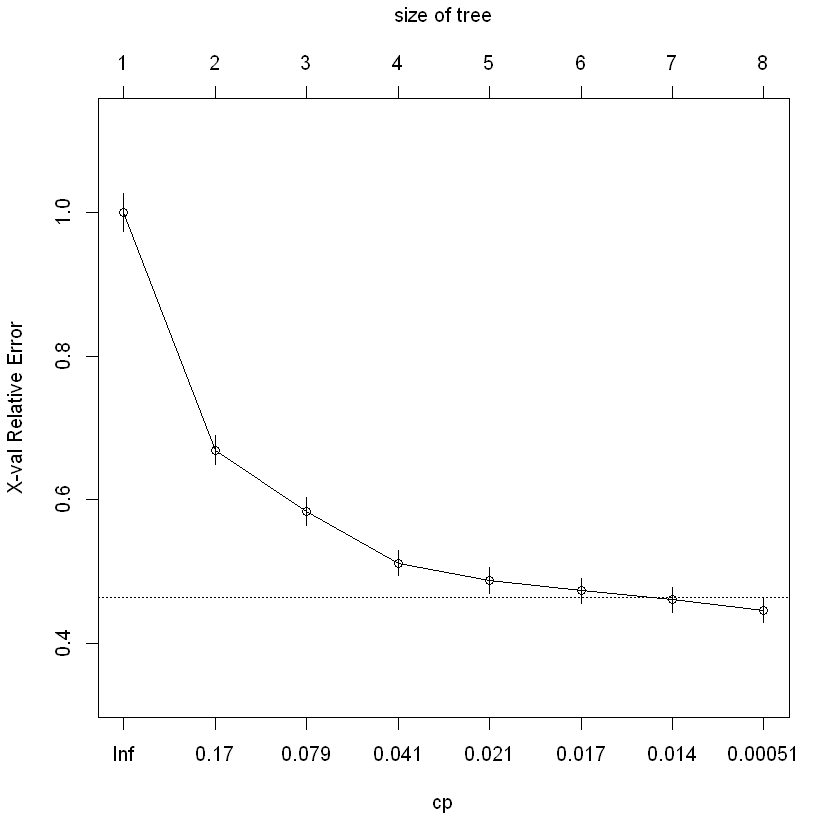

In [63]:
########################  Build Trees with different Leave Sizes  ########################                         

# Prepare data for tree estimator
tree_data_obs <-  data.frame(final_price_obs, baseline_covariates_obs)
empty <- as.matrix(final_price_hold_out)
empty[1,] <-NA
tree_data_hold_out <- data.frame(rbind(final_price_obs,empty),rbind(baseline_covariates_obs, baseline_covariates_hold_out))

# Setup the formula of the linear regression model
sumx <- paste(baseline_covariates, collapse = " + ")  
linear <- paste("final_price_obs",paste(sumx, sep=" + "), sep=" ~ ")
linear <- as.formula(linear)

# Build the tree
linear.singletree_1 <- rpart(formula = linear, data = tree_data_obs , method = "anova", xval = 10,
                             y = TRUE, control = rpart.control(cp = 0.00002, minbucket=500))
# Note: 'minbucket=500' imposes the restriction that each terminal leave should contain at least 500 used cars. Algorithm 'rpart' stops growing trees when either one leave has less than 500 observations or the MSE gain of addidng one addidtional leave is below cp=0.00002.

print('Relative CV-MSE for different tree sizes')
print(linear.singletree_1$cptable)

# Plot CV-MSE
plotcp(linear.singletree_1)

# Save CV-MSE as png-file
#png(filename= "cp_tree1.png", units="in", width=5, height=4, pointsize=12, res=72)
#plotcp(linear.singletree_1)
#dev.off()

In the next step, you select the tree that minimises the CV-MSE.

In [64]:
########################  Select the Tree that Minimises CV-MSE  ######################## 

op.index_1 <- which.min(linear.singletree_1$cptable[, "xerror"])
print(paste0("Optimal number final leaves: ", op.index_1))

# Get cp-value that corresponds to optimal tree size
cp.vals_1 <- linear.singletree_1$cptable[op.index_1, "CP"]

[1] "Optimal number final leaves: 8"


The CV-MSE is minimised at the maximum leave size of eight. This suggests that the tree is not deep enough to unfold the bias-variance trade-off. For illustrational purposes, we continue working with this shallow tree, but later we will relax the restrictions on the minimum leave size.

Now you estimate the optimal tree and estimate out-of-sample RMSE and $R^2$ to compare the relative performance of different approaches.

In [65]:
########################  Select the Optimal Tree and Assess Out-of-Sample Performance  ######################## 

# Prune the tree
treepruned.linearsingle_1 <- prune(linear.singletree_1, cp = cp.vals_1)

# Predict final price in the observed and hold-out-samples
pred_tree_hold_out_1 <- as.matrix(predict(treepruned.linearsingle_1, newdata=tree_data_hold_out))
pred_tree_obs_1 <- pred_tree_hold_out_1[c(1:nrow(tree_data_obs)),]
r <-nrow(final_price_obs)+1
pred_tree_hold_out_1 <- pred_tree_hold_out_1[c(r:nrow(pred_tree_hold_out_1)),]

## Assess performance of tree estimator
# In-sample RMSE
rmse_obs_1 <- round(sqrt(mean((final_price_obs - pred_tree_obs_1)^2)),digits=3)
# Hold-out-sample RMSE
rmse_hold_out_1 <- round(sqrt(mean((final_price_hold_out - pred_tree_hold_out_1)^2)),digits=3)
# In-sample R-squared
r2_obs_1 <- round(1-mean((final_price_obs - pred_tree_obs_1)^2)/mean((final_price_obs - mean(final_price_obs))^2),digits=3)
# Hold-out-sample R-squared
r2_hold_out_1 <- round(1-mean((final_price_hold_out - pred_tree_hold_out_1)^2)/mean((final_price_hold_out - mean(final_price_hold_out))^2),digits=3)

print(paste0("In-Sample RMSE: ", rmse_obs_1))
print(paste0("Hold-out-Sample RMSE: ", rmse_hold_out_1))
print(paste0("In-Sample R-squared: ", r2_obs_1))
print(paste0("Hold-out-Sample R-squared: ", r2_hold_out_1))

[1] "In-Sample RMSE: 4.696"
[1] "Hold-out-Sample RMSE: 4.699"
[1] "In-Sample R-squared: 0.561"
[1] "Hold-out-Sample R-squared: 0.542"


By splitting the sample into eight groups, you can explain already 54\% of the out-of-sample *final_price*. Next, you visualise the tree by plotting the tree structure.

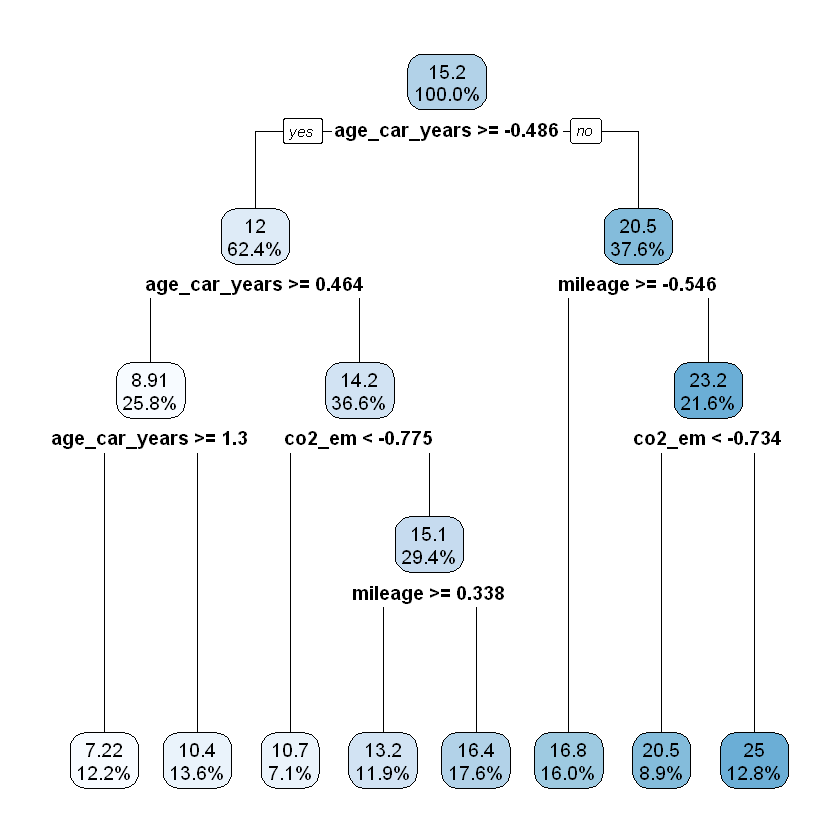

In [66]:
########################  Visulatisation of tree  ######################## 

## Plot tree structure
#plot(treepruned.linearsingle_1,digits=3)
# Note: All continuous variables are standardised.

# Save tree structure as png-file
#png(filename= "full_tree1.png",units="in", width=9, height=9, pointsize=12,res=72)
rpart.plot(treepruned.linearsingle_1,digits=3)
#dev.off()


You have to be careful when interpreting the leaves of the tree. That some sample splits are based on, e.g., *car_age_years* does not necessarily mean that *car_age_years* causally affects *final_price*. The reason is, *car_age_years* is correlated with several other covartiates (e.g., *mileage* and *co2_em*). Possibly, the causal effect operates through one of the correlated covariates and *car_age_years* is just a good proxy. To demonstrate this, you plot in the next step the average regressor value for each leaf.


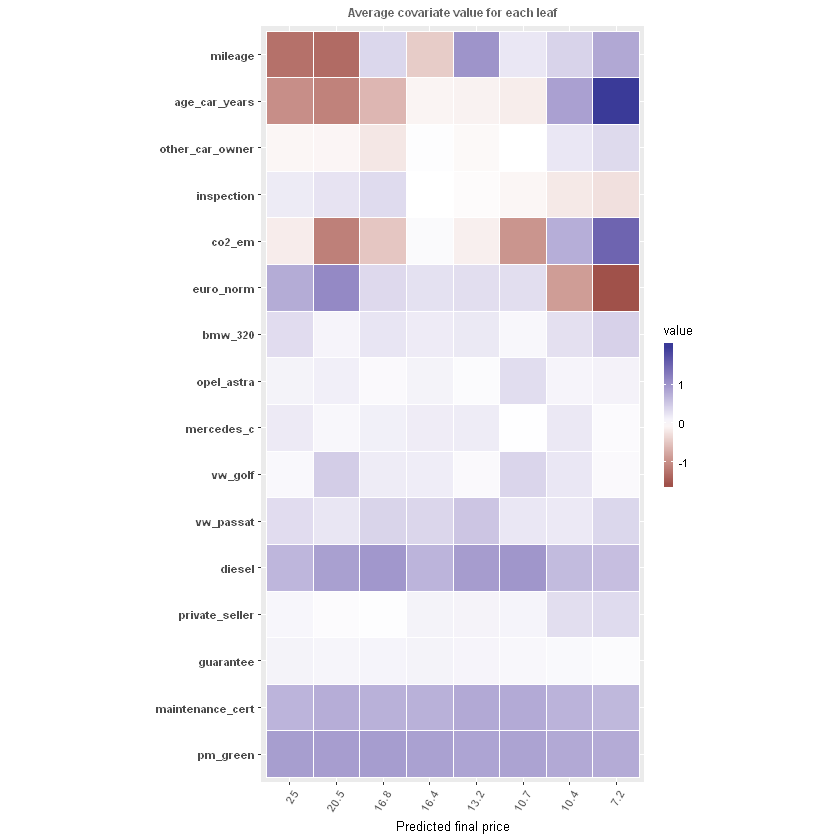

In [67]:
########################  Plot Average Regresor Value for Each Leaf  ######################## 
## Code from Susan Athey and Guido Imbens AEA lecture

# Take hold-out data only
tree_data_out <- data.frame(pred_tree_hold_out_1, baseline_covariates_hold_out)

# Map to each individual row the leaf number and add the covariates
individual_leaf <- treeClust::rpart.predict.leaves(treepruned.linearsingle_1, tree_data_out)  %>% 
  as_tibble()  %>% 
  dplyr::rename(leaf=value) 
leaf_covariates <- cbind(individual_leaf, tree_data_out[baseline_covariates])

# Get predicted final price of each leaf 
leaf_price <- treepruned.linearsingle_1$frame %>% as_tibble() %>%
  dplyr::mutate(row = 1:nrow(.)) %>% 
  dplyr::filter(var == "<leaf>") %>% 
  dplyr::rename(leaf=row, pred_price=yval) %>% 
  dplyr::select(leaf, pred_price) 

# Merge all the information on leaf level
leaf_data <- left_join(leaf_covariates, leaf_price, by="leaf")

# Mean of each covariate on each leaf, 
# Leafs sorted and renumbered by predicted prive
leaf_mean <- leaf_data %>% 
  dplyr::group_by(leaf) %>%
  dplyr::summarise_all(mean) %>%
  dplyr::arrange(desc(pred_price)) %>%
  dplyr::mutate(leaf = 1:nrow(.)) 

# Plot
plt <- leaf_mean %>% 
  dplyr::select(leaf, baseline_covariates[c(16:1)]) %>%
  melt(id="leaf") %>%
  ggplot(aes(x=factor(leaf), y=variable, fill=value)) +
  geom_raster() +
  scale_fill_gradient2() + 
  scale_x_discrete(breaks=seq_along(leaf_mean$pred_price),      
                   labels=round(leaf_mean$pred_price, 1)) +
  # From here on, all the code is optional styling
  geom_tile(colour="white",size=0.25) +            # white cell border
  labs(x="Predicted final price",
       y="", title="Average covariate value for each leaf") +# axis labels 
  coord_fixed()+                                   # square cells
  theme_grey(base_size=8)+                         # basic hue 
  theme(
    axis.text=element_text(face="bold"),      # axis font style
    plot.background=element_blank(),          # cleaner background
    panel.border=element_blank(),             # cleaner panel
    legend.key.width=grid::unit(0.2,"cm"),    # slim legend color bar
    axis.ticks=element_line(size=0.4),        # tick style
    axis.text.x=element_text(size=7,          # tick label style
                             colour="grey40",
                             angle = 60,
                             hjust = 1),
    plot.title=element_text(colour="grey40",  # plot title style
                            hjust=.5,size=7,
                            face="bold")
  )

plot(plt)

# Save average covariate values as png-file
#png(filename= "regressor_values.png",units="in", width=6, height=6, pointsize=38,res=300)
#plt
#dev.off()

The structure of the average covariates is similar for *milage*, *age_car_years* and negatively correlated with *inspection* and *euro_norm*. Accordingly, all of these variables could to some extend replace each other for the prediction of *final_price*. If anything, those covariates with little variation in the colour are less important to predict *final_price*.

## Deep Tree

In [68]:
#Now you relax the restriction on the minimum leave size.

[1] "Optimal number final leaves: 134"


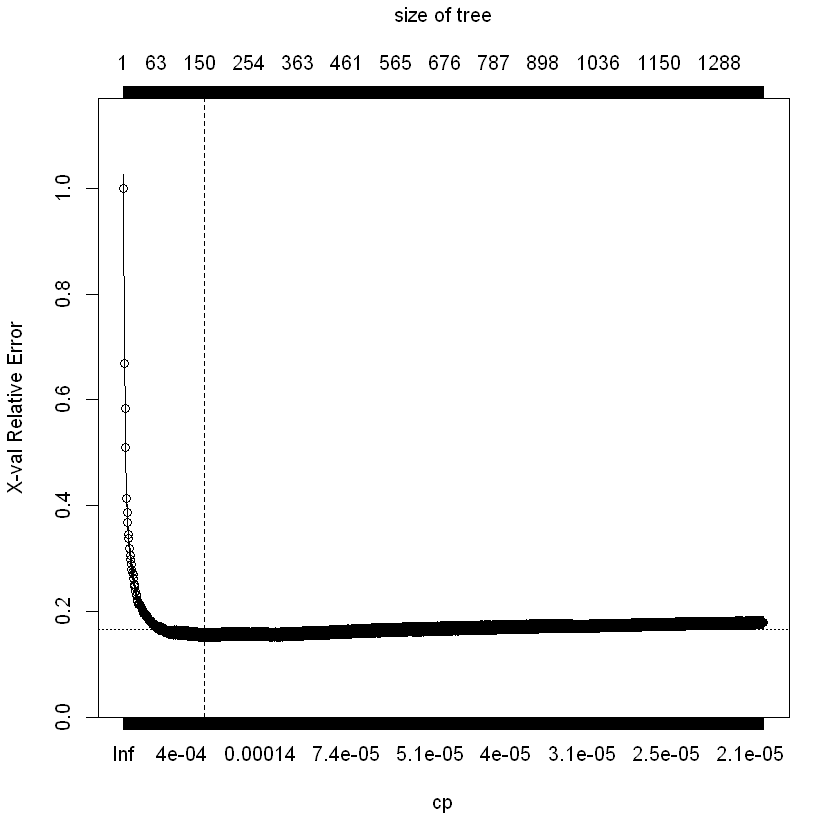

In [69]:
######################## Deep tree estimator  ########################                         

# Build deep Tree
linear.singletree_2 <- rpart(formula = linear, data = tree_data_obs , method = "anova", xval = 10,
                             y = TRUE, control = rpart.control(cp = 0.00002, minbucket=1))

# Find tree size that minimises CV-MSE
op.index_2 <- which.min(linear.singletree_2$cptable[, "xerror"])
print(paste0("Optimal number final leaves: ", op.index_2))

# Plot CV-MSE
plotcp(linear.singletree_2)
abline(v = op.index_2, lty = "dashed")


Warning message:
"labs do not fit even at cex 0.15, there may be some overplotting"

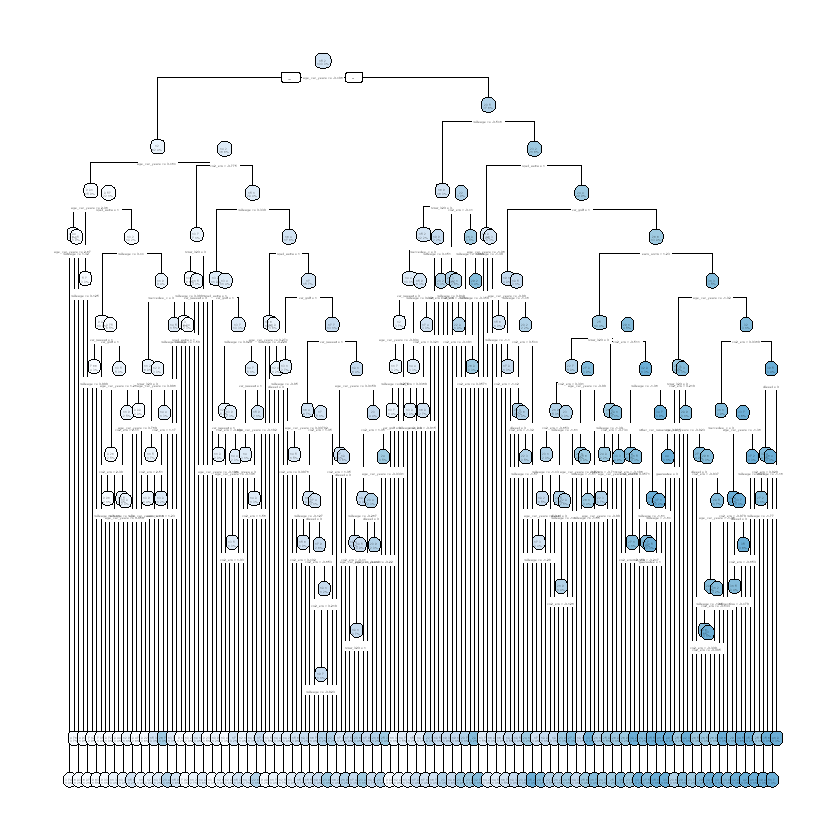

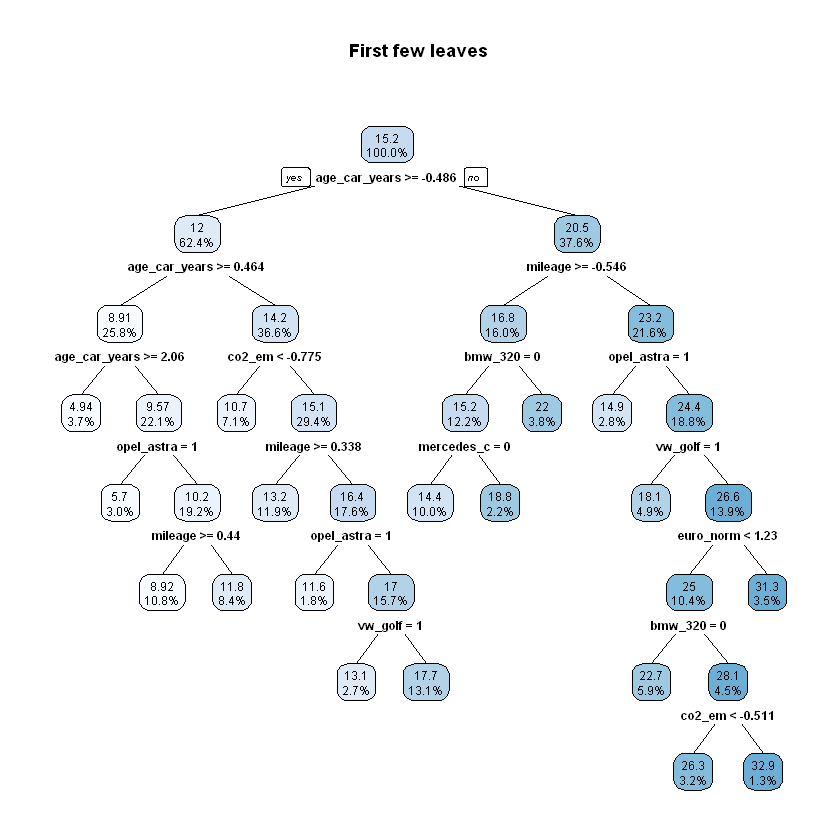

In [70]:
# Get cp-value that corresponds to optimal tree size
cp.vals_2 <- linear.singletree_2$cptable[op.index_2, "CP"]

# Prune the tree
treepruned.linearsingle_2 <- prune(linear.singletree_2, cp = cp.vals_2)

# Plot tree structure
rpart.plot(treepruned.linearsingle_2,digits=3)
treepruned.linearsingle_2_short <- prune(linear.singletree_2, cp = 25*cp.vals_2)
rpart.plot(treepruned.linearsingle_2_short,digits=3, main = "First few leaves",fallen.leaves=FALSE)


In [71]:
# Predict final price in the observed and hold-out-samples
pred_tree_hold_out_2 <- as.matrix(predict(treepruned.linearsingle_2, newdata=tree_data_hold_out))
pred_tree_obs_2 <- pred_tree_hold_out_2[c(1:nrow(tree_data_obs)),]
r <-nrow(final_price_obs)+1
pred_tree_hold_out_2 <- pred_tree_hold_out_2[c(r:nrow(pred_tree_hold_out_2)),]

## Assess performance of tree estimator
# In-sample RMSE
rmse_obs_2 <- round(sqrt(mean((final_price_obs - pred_tree_obs_2)^2)),digits=3)
# Hold-out-sample RMSE
rmse_hold_out_2 <- round(sqrt(mean((final_price_hold_out - pred_tree_hold_out_2)^2)),digits=3)
# In-sample R-squared
r2_obs_2 <- round(1-mean((final_price_obs - pred_tree_obs_2)^2)/mean((final_price_obs - mean(final_price_obs))^2),digits=3)
# Hold-out-sample R-squared
r2_hold_out_2 <- round(1-mean((final_price_hold_out - pred_tree_hold_out_2)^2)/mean((final_price_hold_out - mean(final_price_hold_out))^2),digits=3)

print(paste0("In-Sample RMSE: ", rmse_obs_2))
print(paste0("Hold-out-Sample RMSE: ", rmse_hold_out_2))
print(paste0("In-Sample R-squared: ", r2_obs_2))
print(paste0("Hold-out-Sample R-squared: ", r2_hold_out_2))

[1] "In-Sample RMSE: 2.247"
[1] "Hold-out-Sample RMSE: 2.78"
[1] "In-Sample R-squared: 0.9"
[1] "Hold-out-Sample R-squared: 0.84"


## Deep Honest Tree

[1] "Optimal number final leaves: 144"
[1] "Training-Sample RMSE: 2.202"
[1] "Estimation-Sample RMSE: 2.744"
[1] "Hold-out-Sample RMSE: 2.943"
[1] "Training-Sample R-squared: 0.904"
[1] "Estimation-Sample R-squared: 0.85"
[1] "Hold-out-Sample R-squared: 0.82"


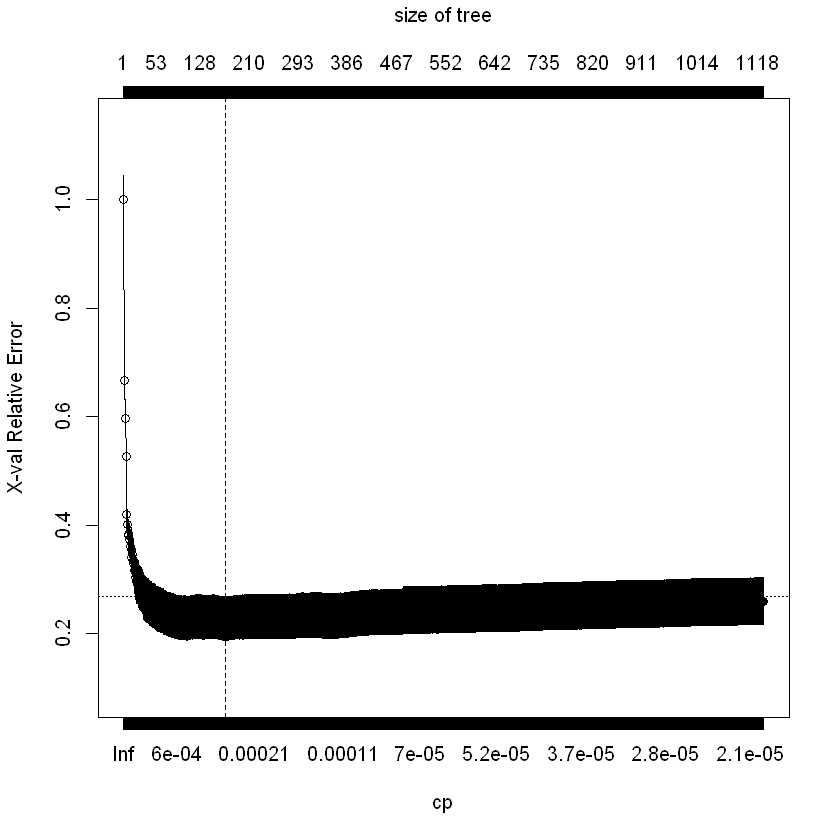

In [72]:
######################## Honest deep tree estimator ########################                        

# Create tratining and estimation sample
df_obs_part <- modelr::resample_partition(df_obs, c(train = 0.5, est = 0.5))
df_train <- as.data.frame(df_obs_part$train)
df_est <- as.data.frame(df_obs_part$est)

# Outcomes
final_price_train <- as.matrix(df_train[,2])
final_price_est <- as.matrix(df_est[,2])

# Covariates/Features
baseline_covariates_hold_cont_out <- as.matrix(df_hold_out[,c(4:9)])
baseline_covariates_cont_train <- as.matrix(df_train[,c(4:9)]) 
baseline_covariates_cont_est <- as.matrix(df_est[,c(4:9)])
baseline_covariates_hold_bin_out <- as.matrix(df_hold_out[,c(10:19)])
baseline_covariates_bin_train <- as.matrix(df_train[,c(10:19)]) 
baseline_covariates_bin_est <- as.matrix(df_est[,c(10:19)])

# Scale continuous variables
preProcValues <- preProcess(baseline_covariates_cont_train, method = c("center", "scale"))
TrainTransformed <- predict(preProcValues, baseline_covariates_cont_train)
HoldOutTransformed <- predict(preProcValues, baseline_covariates_hold_cont_out)
EstTransformed <- predict(preProcValues, baseline_covariates_cont_est)

baseline_covariates_hold_out <- as.matrix(cbind(HoldOutTransformed,baseline_covariates_hold_bin_out)) 
baseline_covariates_train <- as.matrix(cbind(TrainTransformed,baseline_covariates_bin_train)) 
baseline_covariates_est <- as.matrix(cbind(EstTransformed,baseline_covariates_bin_est)) 

# Prepare data for tree estimator
tree_data_train <-  data.frame(final_price_train, baseline_covariates_train)
empty1 <- as.matrix(final_price_train)
empty1[1,] <-NA
empty2 <- as.matrix(final_price_hold_out)
empty2[1,] <-NA
tree_data_hold_out <-  data.frame(rbind(empty1,final_price_est,empty2),rbind(baseline_covariates_train,baseline_covariates_est, baseline_covariates_hold_out))

# Setup the formula of the linear regression model
linear <- paste("final_price_train",paste(sumx, sep=" + "), sep=" ~ ")
linear <- as.formula(linear)

# Build deep tree
linear.singletree_3 <- rpart(formula = linear, data = tree_data_train , method = "anova", xval = 10,
                             y = TRUE, control = rpart.control(cp = 0.00002, minbucket=1))


# Find tree size that minimises CV-MSE
op.index_3 <- which.min(linear.singletree_3$cptable[, "xerror"])
print(paste0("Optimal number final leaves: ", op.index_3))

# Plot CV-MSE
plotcp(linear.singletree_3)
abline(v = op.index_3, lty = "dashed")

# Get cp-value that corresponds to optimal tree size
cp.vals_3 <- linear.singletree_3$cptable[op.index_3, "CP"]

# Prune the tree
treepruned.linearsingle_3 <- prune(linear.singletree_3, cp = cp.vals_3)

# Predict final price in the observed and hold-out-samples
pred_tree_hold_out_3 <- as.matrix(predict(treepruned.linearsingle_3, newdata=tree_data_hold_out))
pred_tree_train_3 <- pred_tree_hold_out_3[c(1:nrow(final_price_train)),]
r <-nrow(final_price_train)+1
pred_tree_est_3 <- pred_tree_hold_out_3[c(r:nrow(final_price_obs)),]
r <-nrow(final_price_obs)+1
pred_tree_hold_out_3 <- pred_tree_hold_out_3[c(r:nrow(pred_tree_hold_out_3)),]

## Assess performance of tree estimator
# Training-sample RMSE
rmse_train_3 <- round(sqrt(mean((final_price_train - pred_tree_train_3)^2)),digits=3)
# Estimation-sample RMSE
rmse_est_3 <- round(sqrt(mean((final_price_est - pred_tree_est_3)^2)),digits=3)
# Hold-out-sample RMSE
rmse_hold_out_3 <- round(sqrt(mean((final_price_hold_out - pred_tree_hold_out_3)^2)),digits=3)
# Training-sample R-squared
r2_train_3 <- round(1-mean((final_price_train - pred_tree_train_3)^2)/mean((final_price_train - mean(final_price_train))^2),digits=3)
# Estimation-sample R-squared
r2_est_3 <- round(1-mean((final_price_est - pred_tree_est_3)^2)/mean((final_price_est - mean(final_price_est))^2),digits=3)
# Hold-out-sample R-squared
r2_hold_out_3 <- round(1-mean((final_price_hold_out - pred_tree_hold_out_3)^2)/mean((final_price_hold_out - mean(final_price_hold_out))^2),digits=3)

print(paste0("Training-Sample RMSE: ", rmse_train_3))
print(paste0("Estimation-Sample RMSE: ", rmse_est_3))
print(paste0("Hold-out-Sample RMSE: ", rmse_hold_out_3))
print(paste0("Training-Sample R-squared: ", r2_train_3))
print(paste0("Estimation-Sample R-squared: ", r2_est_3))
print(paste0("Hold-out-Sample R-squared: ", r2_hold_out_3))


## Deep Honest Cross-Fitted Tree

[1] "Optimal number final leaves: 160"
[1] "Optimal number final leaves: 120"


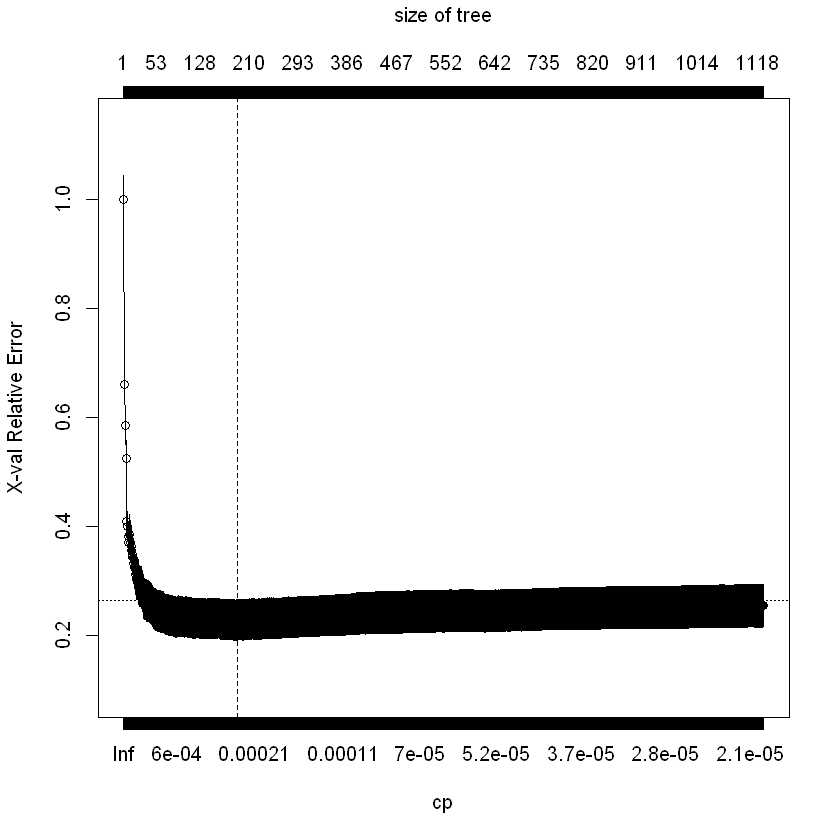

[1] "Hold-out-Sample RMSE: 2.725"
[1] "Hold-out-Sample R-squared: 0.846"


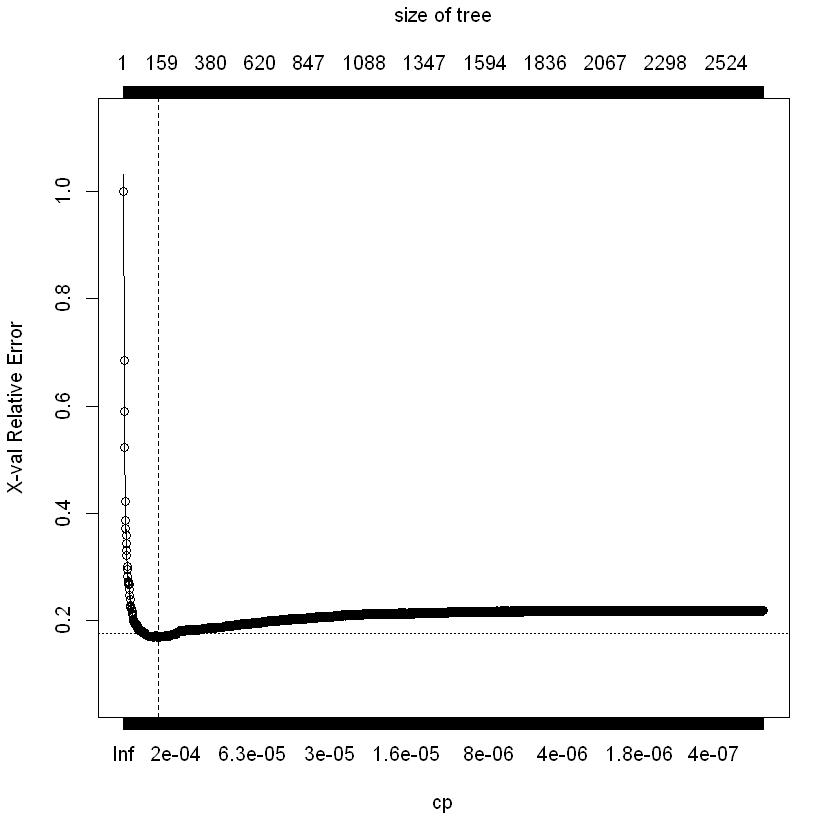

In [73]:
########################  Crosfitted honest deep tree estimator  ########################                        

# Alternate tratining and estimation sample
tree_data_train1 <-  data.frame(final_price_train, baseline_covariates_train)
tree_data_train2 <-  data.frame(final_price_est, baseline_covariates_est)

# Prepare both data data for tree estimator
empty1 <- as.matrix(final_price_train)
empty1[1,] <-NA
empty2 <- as.matrix(final_price_hold_out)
empty2[1,] <-NA
tree_data_hold_out1 <-  data.frame(rbind(empty1,final_price_est,empty2),rbind(baseline_covariates_train,baseline_covariates_est, baseline_covariates_hold_out))

empty1 <- as.matrix(final_price_est)
empty1[1,] <-NA
empty2 <- as.matrix(final_price_hold_out)
empty2[1,] <-NA
tree_data_hold_out2 <-  data.frame(rbind(final_price_train,empty1,empty2),rbind(baseline_covariates_train,baseline_covariates_est, baseline_covariates_hold_out))

#####

# Setup the formula of the linear regression model for the first tree
linear <- paste("final_price_train",paste(sumx, sep=" + "), sep=" ~ ")
linear <- as.formula(linear)

# Build first deep tree
linear.singletree_4 <- rpart(formula = linear, data = tree_data_train1 , method = "anova", xval = 10,
                             y = TRUE, control = rpart.control(cp = 0.00002, minbucket=1))


# Find tree size that minimises CV-MSE
op.index_4 <- which.min(linear.singletree_4$cptable[, "xerror"])
print(paste0("Optimal number final leaves: ", op.index_4))

# Plot CV-MSE
plotcp(linear.singletree_4)
abline(v = op.index_4, lty = "dashed")

# Get cp-value that corresponds to optimal tree size
cp.vals_4 <- linear.singletree_4$cptable[op.index_4, "CP"]

# Prune the tree
treepruned.linearsingle_4 <- prune(linear.singletree_4, cp = cp.vals_4)

# Predict final price in the hold-out-sample
pred_tree_hold_out_4 <- as.matrix(predict(treepruned.linearsingle_4, newdata=tree_data_hold_out1))
r <-nrow(final_price_obs)+1
pred_tree_hold_out_4 <- pred_tree_hold_out_4[c(r:nrow(pred_tree_hold_out_4)),]

#####

# Setup the formula of the linear regression model for the second tree
linear <- paste("final_price_est",paste(sumx, sep=" + "), sep=" ~ ")
linear <- as.formula(linear)

# Build second deep tree
linear.singletree_5 <- rpart(formula = linear, data = tree_data_train2 , method = "anova", xval = 10,
                             y = TRUE, control = rpart.control(cp = 0.00000001, minbucket=1))


# Find tree size that minimises CV-MSE
op.index_5 <- which.min(linear.singletree_5$cptable[, "xerror"])
print(paste0("Optimal number final leaves: ", op.index_5))

# Plot CV-MSE
plotcp(linear.singletree_5)
abline(v = op.index_5, lty = "dashed")

# Get cp-value that corresponds to optimal tree size
cp.vals_5 <- linear.singletree_5$cptable[op.index_5, "CP"]

# Prune the tree
treepruned.linearsingle_5 <- prune(linear.singletree_5, cp = cp.vals_5)

# Predict final price in the hold-out-sample
pred_tree_hold_out_5 <- as.matrix(predict(treepruned.linearsingle_5, newdata=tree_data_hold_out2))
r <-nrow(final_price_obs)+1
pred_tree_hold_out_5 <- pred_tree_hold_out_5[c(r:nrow(pred_tree_hold_out_5)),]

#####

## Assess performance of tree estimator
# Hold-out-sample RMSE
rmse_hold_out_4 <- round(sqrt(mean((final_price_hold_out - 0.5*(pred_tree_hold_out_4 + pred_tree_hold_out_5))^2)),digits=3)
# Hold-out-sample R-squared
r2_hold_out_4 <- round(1-mean((final_price_hold_out - 0.5*(pred_tree_hold_out_4 + pred_tree_hold_out_5))^2)/mean((final_price_hold_out - mean(final_price_hold_out))^2),digits=3)

print(paste0("Hold-out-Sample RMSE: ", rmse_hold_out_4))
print(paste0("Hold-out-Sample R-squared: ", r2_hold_out_4))

# Random Forest

In [74]:
########################  Random forest estimator  ######################## 

# Tuning parameters
min_tree = 1
num_trees = 500
cov_frac = 2/3

# Build random forest
forest <- regression_forest(baseline_covariates_obs, final_price_obs, sample.fraction = 0.5, 
                  mtry = floor(cov_frac*ncol(baseline_covariates_obs)),
                  num.trees = num_trees, min.node.size = min_tree,
                  honesty = TRUE, honesty.fraction = 0.5)

# Predict prices in hold-out-sample
pred_forest <- predict(forest, newdata = baseline_covariates_hold_out)

## Assess performance of forest estimator
# Hold-out-sample RMSE
rmse_forest <- round(sqrt(mean((final_price_hold_out - pred_forest$predictions)^2)),digits=3)
# Hold-out-sample R-squared
r2_forest <- round(1-mean((final_price_hold_out - pred_forest$predictions)^2)/mean((final_price_hold_out - mean(final_price_hold_out))^2),digits=3)

print(paste0("Hold-out-Sample RMSE: ", rmse_forest))
print(paste0("Hold-out-Sample R-squared: ", r2_forest))


[1] "Hold-out-Sample RMSE: 2.543"
[1] "Hold-out-Sample R-squared: 0.866"


In [75]:
# Number of splits by covariate and tree depht
split <- split_frequencies(forest, max.depth = 4)
colnames(split) <- baseline_covariates
print(split)

     mileage age_car_years other_car_owner inspection co2_em euro_norm bmw_320
[1,]     108           303               2          0     19        49       1
[2,]     220           479               0          0      9       167      56
[3,]     253           513               4          1    232        82     254
[4,]     792           866              33         29    500       138     341
     opel_astra mercedes_c vw_golf vw_passat diesel private_seller guarantee
[1,]         11          4       0         0      0              3         0
[2,]         30         21       9         0      5              2         0
[3,]        311        205     122         4      7              1         1
[4,]        536        355     261        18     43             17        19
     maintenance_cert pm_green
[1,]                0        0
[2,]                1        1
[3,]                5        5
[4,]               34       16


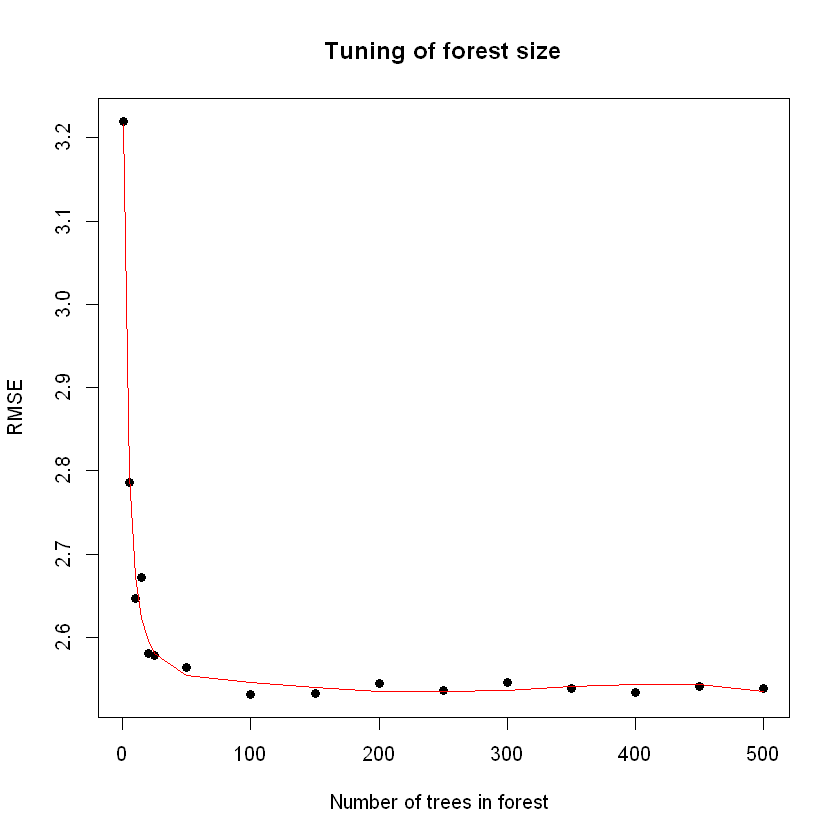

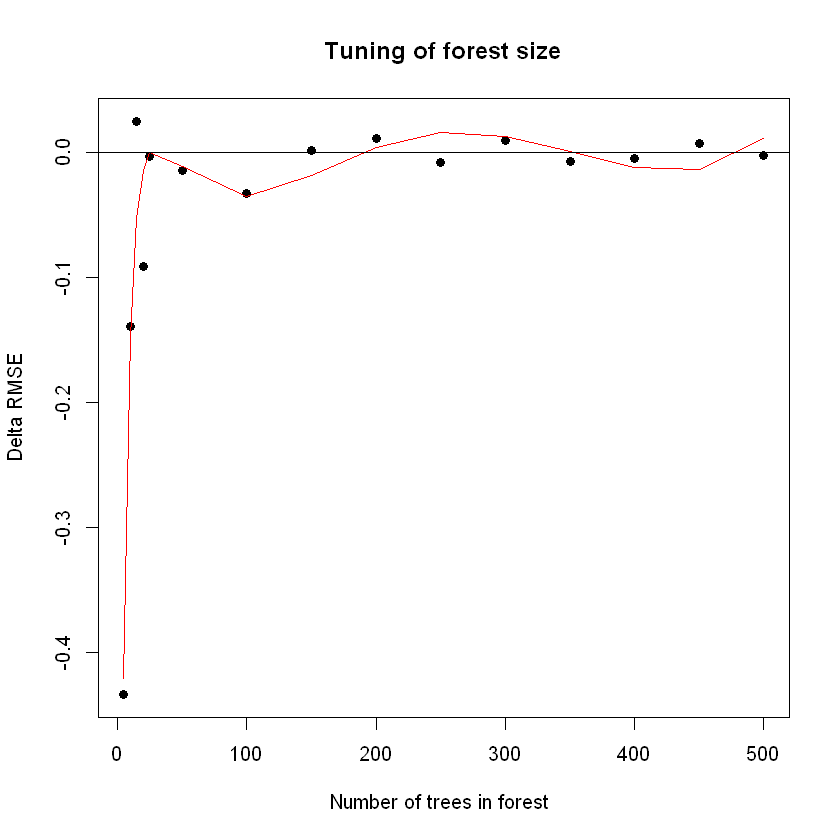

In [76]:
# Select tuning parameters for forest
#for_sizes = c(1,5, 10,15, 20,25,50,100,150,200,250, 300,350, 400, 450, 500, 1000, 1500, 2000, 3000, 4000, 5000, 10000)
for_sizes = c(1,5, 10,15, 20,25,50,100,150,200,250, 300,350, 400, 450, 500)
auc <- matrix(NA,nrow=length(for_sizes),ncol=3)
ctr <- 0
for (n in for_sizes){
  ctr <- ctr + 1
  auc[ctr,1] <- n
  
  forest <- regression_forest(baseline_covariates_obs, final_price_obs, sample.fraction = 0.5, 
                              mtry = floor(cov_frac*ncol(baseline_covariates_obs)),
                              num.trees = n, min.node.size = min_tree,
                              honesty = TRUE, honesty.fraction = 0.5)
  
  # Predict prices in hold-out-sample
  pred_forest <- predict(forest, newdata = baseline_covariates_hold_out)
  rmse_forest <- round(sqrt(mean((final_price_hold_out - pred_forest$predictions)^2)),digits=3)
  auc[ctr,2] <- rmse_forest
  if (ctr >1) {
    auc[ctr,3] <- rmse_forest-auc[ctr-1,2]
  }
}

plot(auc[,1], auc[,2], main="Tuning of forest size", 
     xlab="Number of trees in forest ", ylab="RMSE", pch=19)
# fit a non-linear regression
nls_fit <- lm(auc[,2] ~  auc[,1] + I(auc[,1]^(1/2)) + I(auc[,1]^2) + I(auc[,1]^3) + I(log(auc[,1])))
lines(auc[,1], predict(nls_fit), col = "red")

plot(auc[c(2:nrow(auc)),1], auc[c(2:nrow(auc)),3], main="Tuning of forest size", 
     xlab="Number of trees in forest ", ylab="Delta RMSE", pch=19)
# fit a non-linear regression
nls_fit <- lm(auc[c(2:nrow(auc)),3] ~  auc[c(2:nrow(auc)),1] + I(auc[c(2:nrow(auc)),1]^(1/2)) + I(auc[c(2:nrow(auc)),1]^2) + I(auc[c(2:nrow(auc)),1]^3) + I(log(auc[c(2:nrow(auc)),1])))
lines(auc[c(2:nrow(auc)),1], predict(nls_fit), col = "red")
abline(h=0)


# Save graph
#png(filename= "auc.png",units="in", width=6, height=6, pointsize=10,res=300)
#  plot(auc[,1], auc[,2], main="Tuning of forest size", 
#       xlab="Number of trees in forest ", ylab="RMSE", pch=19)
#  # fit a non-linear regression
#  nls_fit <- lm(auc[,2] ~  auc[,1] + I(auc[,1]^(1/2)) + I(auc[,1]^2) + I(auc[,1]^3) + I(log(auc[,1])))
#  lines(auc[,1], predict(nls_fit), col = "red")
#dev.off()

#png(filename= "delta_auc.png",units="in", width=6, height=6, pointsize=10,res=300)
#  plot(auc[c(2:nrow(auc)),1], auc[c(2:nrow(auc)),3], main="Tuning of forest size", 
#       xlab="Number of trees in forest ", ylab="Delta RMSE", pch=19)
#  # fit a non-linear regression
#  nls_fit <- lm(auc[c(2:nrow(auc)),3] ~  auc[c(2:nrow(auc)),1] + I(auc[c(2:nrow(auc)),1]^(1/2)) + I(auc[c(2:nrow(auc)),1]^2) + I(auc[c(2:nrow(auc)),1]^3) + I(log(auc[c(2:nrow(auc)),1])))
#  lines(auc[c(2:nrow(auc)),1], predict(nls_fit), col = "red")
#  abline(h=0)
#dev.off()

# LASSO

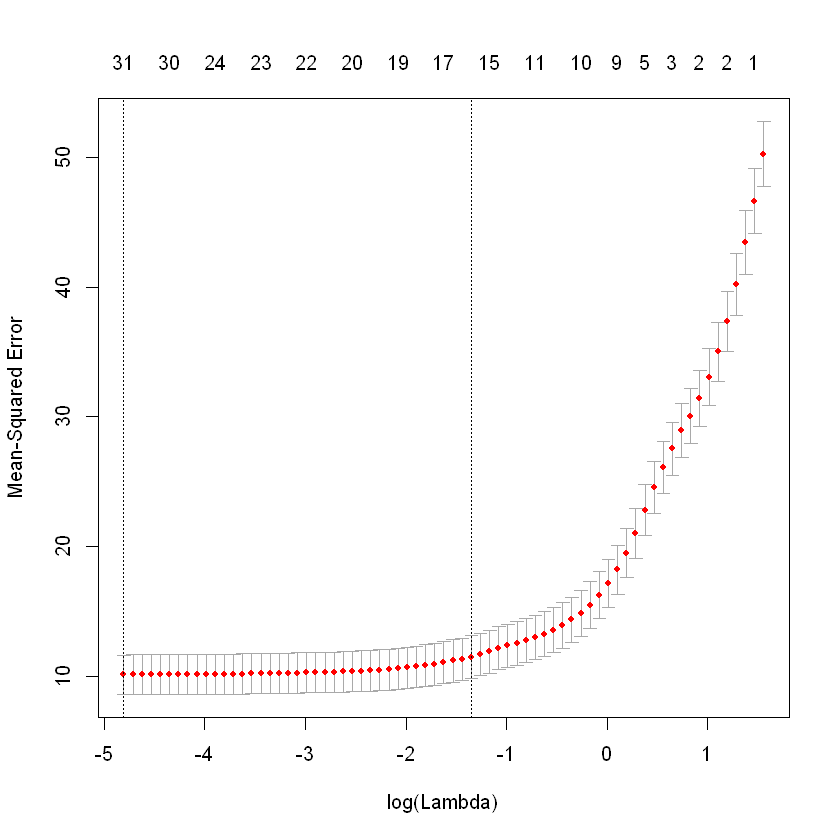

[1] "Lambda minimising CV-MSE: 0.00819599"
[1] "Lambda 1 standard error rule: 0.25935297"
[1] "Hold-out-Sample RMSE: 3.282"
[1] "Hold-out-Sample R-squared: 0.777"


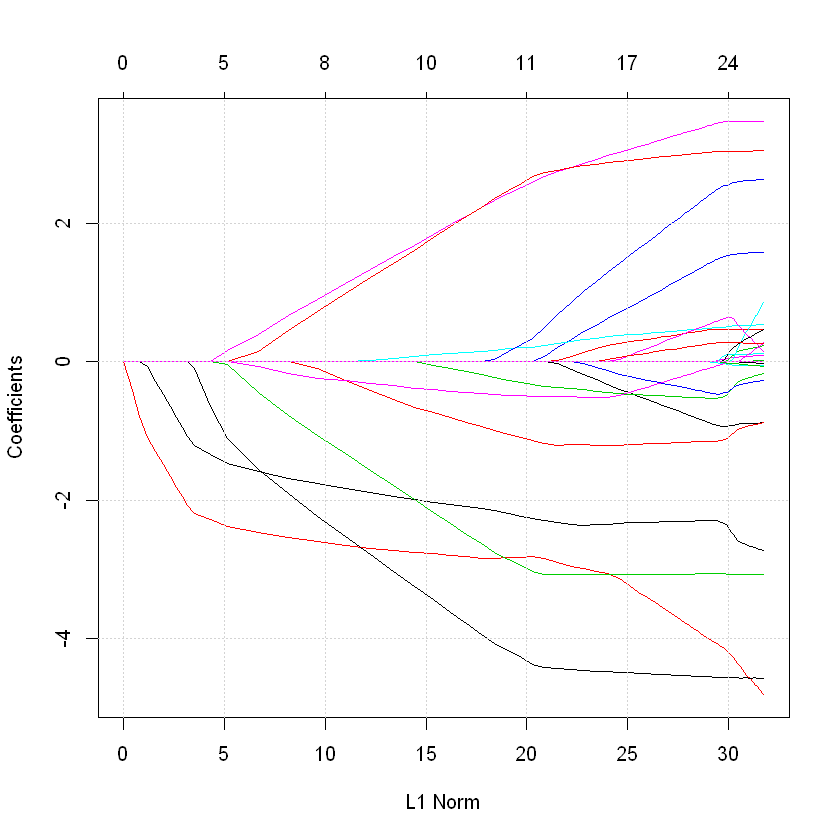

In [77]:
########################  LASSO estimator  ########################

noise.covars.hold.out <- matrix(data = rnorm(nrow(df_hold_out)),  nrow = nrow(df_hold_out), ncol = 13)
names(noise.covars.hold.out) <- c("noise1", "noise2", "noise3", "noise4", "noise5", "noise6", "noise7", "noise8", "noise9", "noise10", "noise11", "noise12","noise13")

noise.covars.est <- matrix(data = rnorm(nrow(df_est)),  nrow = nrow(df_est), ncol = 13)
names(noise.covars.est) <- c("noise1", "noise2", "noise3", "noise4", "noise5", "noise6", "noise7", "noise8", "noise9", "noise10", "noise11", "noise12","noise13")

noise.covars.train <- matrix(data = rnorm(nrow(df_train)),  nrow = nrow(df_train), ncol = 13)
names(noise.covars.train) <- c("noise1", "noise2", "noise3", "noise4", "noise5", "noise6", "noise7", "noise8", "noise9", "noise10", "noise11", "noise12","noise13")


# Prepare LASSO variables
lasso_covariates_hold_out_cont <- as.matrix(df_hold_out[,c(20:25)])
lasso_covariates_est_cont <- as.matrix(df_est[,c(20:25)])
lasso_covariates_train_cont <- as.matrix(df_train[,c(20:25)])

# Scale continuous variables
preProcValues <- preProcess(lasso_covariates_train_cont, method = c("center", "scale"))
TrainTransformed <- predict(preProcValues, lasso_covariates_train_cont)
HoldOutTransformed <- predict(preProcValues, lasso_covariates_hold_out_cont)
EstTransformed <- predict(preProcValues, lasso_covariates_est_cont)

lasso_covariates_hold_out <- as.matrix(cbind(baseline_covariates_hold_out, HoldOutTransformed,df_hold_out[,c(26:ncol(df_hold_out))],noise.covars.hold.out)) 
lasso_covariates_train <- as.matrix(cbind(baseline_covariates_train,TrainTransformed,df_train[,c(26:ncol(df_train))],noise.covars.train)) 
lasso_covariates_est <- as.matrix(cbind(baseline_covariates_est,EstTransformed,df_est[,c(26:ncol(df_est))],noise.covars.est)) 


# Cross-validate Lambda of LASSO model
lasso.linear <- cv.glmnet(lasso_covariates_train, final_price_train,lambda.min = exp(-9),  alpha=1, parallel=FALSE)
plot(lasso.linear)

# Plot coefficient path
lasso.fit2 <- glmnet(lasso_covariates_est , final_price_est)
plot(lasso.fit2)
grid()


print(paste0("Lambda minimising CV-MSE: ", round(lasso.linear$lambda.min,digits=8)))
# 1 standard error rule reduces the number of included covariates
print(paste0("Lambda 1 standard error rule: ", round(lasso.linear$lambda.1se,digits=8)))

# Estimate LASSO model with 1 standard error lambda in estimation sample
lasso.fit <- glmnet(lasso_covariates_est , final_price_est,lambda = lasso.linear$lambda.1se)

# Extrapolate LASSO estimates to hold-out-sample
yhat.lasso <- predict(lasso.fit, lasso_covariates_hold_out)

## Assess performance of LASSO estimator
# Hold-out-sample RMSE
rmse_lasso <- round(sqrt(mean((final_price_hold_out - yhat.lasso)^2)),digits=3)
# Hold-out-sample R-squared
r2_lasso <- round(1-mean((final_price_hold_out - yhat.lasso)^2)/mean((final_price_hold_out - mean(final_price_hold_out))^2),digits=3)

print(paste0("Hold-out-Sample RMSE: ", rmse_lasso))
print(paste0("Hold-out-Sample R-squared: ", r2_lasso))

## Post-Lasso

In [78]:
########################  Post-LASSO estimator  ########################

# Estimate LASSO model with 1 standard error lambda in training sample
lasso.linear.fit <- glmnet(lasso_covariates_train , final_price_train,lambda = lasso.linear$lambda.1se)

# Select covariates with non-zero coefficients
coef <- predict(lasso.linear.fit, type = "nonzero") # Method 2
colnames <- colnames(lasso_covariates_train)
selected.vars <- colnames[unlist(coef)]

# Prepare (unscaled) LASSO variables
lasso_covariates_hold_out <- as.data.frame(cbind(df_hold_out[,c(4:ncol(df_hold_out))],noise.covars.hold.out)) 
lasso_covariates_est <- as.data.frame(cbind(df_est[,c(4:ncol(df_est))],noise.covars.est)) 


# Linear Post-LASSO fit in estimation sample
post.lasso.model <- paste("final_price_est", paste(selected.vars,collapse=" + "),  sep = " ~ ") 
post.lasso.model <- as.formula(post.lasso.model)
post.lasso <- lm(post.lasso.model, data=lasso_covariates_est)
summary(post.lasso)

# Extrapolate Post-LASSO estimates to hold-out-sample
yhat.post.lasso <- predict(post.lasso, newdata=lasso_covariates_hold_out)

## Assess performance of LASSO estimator
# Hold-out-sample RMSE
rmse_post_lasso <- round(sqrt(mean((final_price_hold_out - yhat.post.lasso)^2)),digits=3)
# Hold-out-sample R-squared
r2_post_lasso <- round(1-mean((final_price_hold_out - yhat.post.lasso)^2)/mean((final_price_hold_out - mean(final_price_hold_out))^2),digits=3)

print(paste0("Hold-out-Sample RMSE: ", rmse_post_lasso))
print(paste0("Hold-out-Sample R-squared: ", r2_post_lasso))


Call:
lm(formula = post.lasso.model, data = lasso_covariates_est)

Residuals:
     Min       1Q   Median       3Q      Max 
-12.4248  -1.9858  -0.3258   1.5356  21.8604 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      11.626628   1.061847  10.949  < 2e-16 ***
mileage          -0.046349   0.002454 -18.891  < 2e-16 ***
age_car_years    -1.313078   0.040957 -32.060  < 2e-16 ***
co2_em            0.063585   0.003416  18.616  < 2e-16 ***
euro_norm         1.077703   0.149731   7.198 7.29e-13 ***
bmw_320           3.502099   0.138191  25.342  < 2e-16 ***
opel_astra       -4.576187   0.179899 -25.437  < 2e-16 ***
mercedes_c        3.131568   0.164572  19.029  < 2e-16 ***
vw_golf          -3.064087   0.157327 -19.476  < 2e-16 ***
diesel            2.677459   0.159091  16.830  < 2e-16 ***
pm_green          0.661802   0.152998   4.326 1.56e-05 ***
mile_30          -1.604733   0.287833  -5.575 2.64e-08 ***
mile_40          -0.061987   0.338188  -0.183  

[1] "Hold-out-Sample RMSE: 3.138"
[1] "Hold-out-Sample R-squared: 0.796"
